In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from get_votes import votes

In [2]:
with open("res.pkl", "rb") as f:
    res = pickle.load(f)

In [3]:
def parse_metadata(names):
    pref, _ = names.split(".")
    artist, version, orig, presence = pref.split("-")
    return orig, [int(x) for x in presence]

imgs = np.stack([x["features"] for x in res])
metadata = [parse_metadata(x["img"]) for x in res]
filename_mappings = { x["img"][:-4]: i for i, x in enumerate(res) }

# Part 1: Vote analysis

In [4]:
# Augment dataset with helper features
image_index = pd.Series([filename_mappings[v.split(",")[-1]] for v in votes["combination_id"]])
votes["image_index"] = image_index
chosen_image = pd.Series([v.split(".")[0] for v in votes["chosen_image_filename"]])
votes["chosen_image"] = chosen_image
true_image = pd.Series([metadata[idx][0] for idx in image_index])
votes["true_image"] = true_image

In [5]:
votes

,username,chosen_image_filename,timestamp,combination_id,image_index,chosen_image,true_image
0,99497524,270.jpg,2023-02-17 10:49:52.416634,"1344,270,883,D3-1-270-000010",337,270,270
1,99497524,100.jpg,2023-02-17 10:49:52.416634,"100,1501,1955,D4-3-1501-001000",274,100,1501
2,99497524,1195.jpg,2023-02-17 10:49:52.416634,"1195,1344,1501,D4-3-1344-010001",203,1195,1344
3,99497524,1237.jpg,2023-02-17 10:49:52.416634,"1041,106,1237,D2-1-1041-001000",210,1237,1041
4,99497524,1501.jpg,2023-02-17 10:49:52.416634,"1344,1501,883,D4-2-1344-000010",87,1501,1344
...,...,...,...,...,...,...,...
2000,19038446,100.jpg,2023-02-21 10:33:27.766024,"100,242,354,D2-1-100-011110",386,100,100
2001,19038446,1204.jpg,2023-02-21 10:33:27.766024,"1204,1501,883,D4-3-1204-010100",388,1204,1204
2002,19038446,1955.jpg,2023-02-21 10:33:27.766024,"100,1527,1955,D4-2-1955-010110",335,1955,1955
2003,19038446,1527.jpg,2023-02-21 10:33:27.766024,"1527,270,354,D1-2-1527-101001",185,1527,1527


In [6]:
def proxy_likeness_score(votes):
    accuracy = (votes["chosen_image"] == votes["true_image"]).mean()
    return accuracy

likeness_by_sketch = votes.groupby("image_index").apply(proxy_likeness_score)

(array([  9.,   0.,   0.,   0.,   2.,  18.,   1.,   0.,   4.,   0.,  30.,
          9.,   0.,  11.,   0.,  89.,  11.,   0.,   0., 320.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

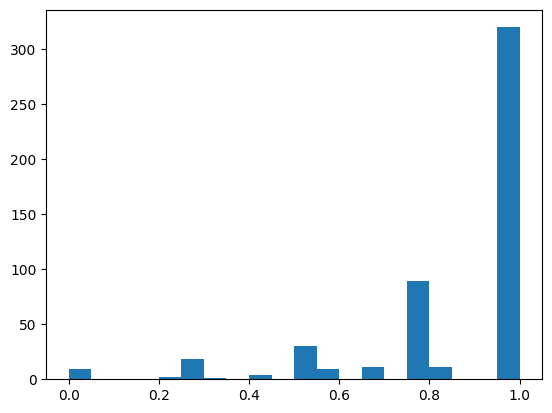

In [7]:
plt.hist(likeness_by_sketch, bins=20)

# Train test split

In [23]:
X = imgs[image_index]
y = chosen_image
z = likeness_by_sketch[image_index]

indices = np.arange(len(res))

i_train, i_test = sklearn.model_selection.train_test_split(indices, test_size=0.4)

train_mask = np.array([x in i_train for x in image_index])
test_mask = ~train_mask
X_train, X_test, Y_train, Y_test, Z_train, Z_test = X[train_mask], X[test_mask], y[train_mask], y[test_mask], z[train_mask], z[test_mask]

# Experiment: Just training a Logistic Regression on the votes and not the truth values

In [32]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, Y_train)

/home/spdskatr/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

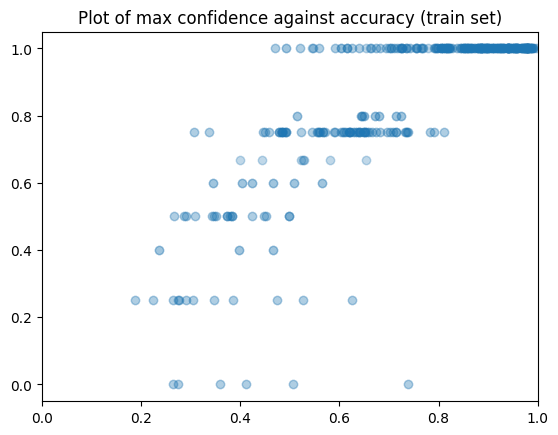

In [33]:
vals = lr.predict_proba(X_train).max(axis=1)
accuracies = Z_train

fig, ax = plt.subplots()

ax.set_title("Plot of max confidence against accuracy (train set)")
ax.set_xlim(left=0)
ax.scatter(vals, accuracies, alpha=0.1)

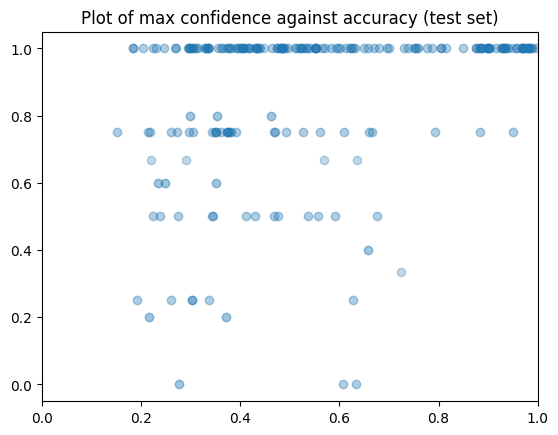

In [34]:
vals = lr.predict_proba(X_test).max(axis=1)
accuracies = Z_test

fig, ax = plt.subplots()

ax.set_title("Plot of max confidence against accuracy (test set)")
ax.set_xlim(left=0)
ax.scatter(vals, accuracies, alpha=0.1)

# Experiment: Training Logistic Regression on accuracy metric

In [37]:
def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def inv_sigmoid(x):
    x = np.clip(x, 0.001, 0.999)
    return -np.log(1/x - 1)

# SKLearn has no Logistic regression regressor, so we have to improvise their linear regression by transforming data under sigmoid
lr2 = Ridge()
lr2.fit(X_train, inv_sigmoid(Z_train))

Ridge()

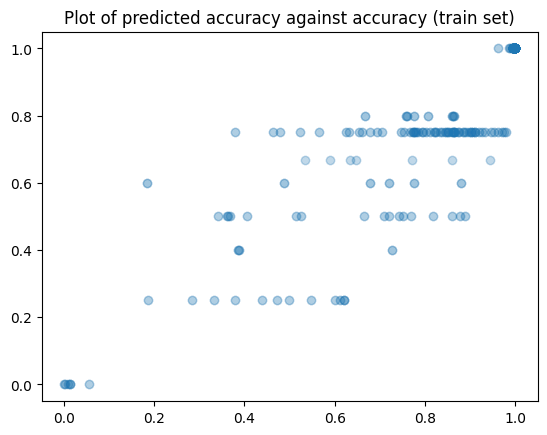

In [38]:
vals = sigmoid(lr2.predict(X_train))
accuracies = Z_train

fig, ax = plt.subplots()

ax.set_title("Plot of predicted accuracy against accuracy (train set)")
ax.scatter(vals, accuracies, alpha=0.1)

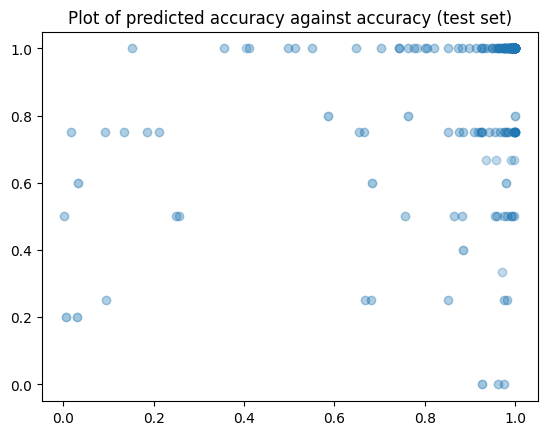

In [39]:
vals = sigmoid(lr2.predict(X_test))
accuracies = Z_test

fig, ax = plt.subplots()

ax.set_title("Plot of predicted accuracy against accuracy (test set)")
ax.scatter(vals, accuracies, alpha=0.1)

# Scratch space

In [13]:
def f1_score(label):
    actual = true_image == label
    predicted = chosen_image == label
    tp = (actual & predicted).sum()
    fp = (~actual & predicted).sum()
    fn = (actual & ~predicted).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return (precision, recall, 2*precision*recall/(precision+recall))

In [14]:
[(x, f1_score(x)) for x in set(true_image)]

[('1041', (0.8333333333333334, 0.8741258741258742, 0.8532423208191126)),
 ('106', (0.8543046357615894, 0.9020979020979021, 0.8775510204081631)),
 ('1344', (0.8145695364238411, 0.8541666666666666, 0.8338983050847457)),
 ('1237', (0.984251968503937, 0.8802816901408451, 0.9293680297397771)),
 ('270', (0.8956521739130435, 0.7357142857142858, 0.807843137254902)),
 ('1501', (0.8840579710144928, 0.8591549295774648, 0.8714285714285713)),
 ('1204', (0.8263473053892215, 0.9452054794520548, 0.8817891373801918)),
 ('1955', (0.9140625, 0.8297872340425532, 0.8698884758364313)),
 ('1195', (0.8355263157894737, 0.8819444444444444, 0.8581081081081081)),
 ('354', (0.7225806451612903, 0.7832167832167832, 0.7516778523489933)),
 ('883', (0.7924528301886793, 0.8811188811188811, 0.8344370860927153)),
 ('1527', (0.916030534351145, 0.821917808219178, 0.8664259927797834)),
 ('100', (0.8367346938775511, 0.8424657534246576, 0.8395904436860068)),
 ('242', (0.8432835820895522, 0.795774647887324, 0.818840579710145))]